In [85]:
import os
import tensorflow as tf
import numpy as np
import matplotlib
import pandas as pd
matplotlib.use('agg')
import matplotlib.pyplot as plt
import random
import re

from sklearn import model_selection

/home/asr/tensorflow-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  Fi

In [86]:
from stop_words import get_stop_words

In [87]:
ROOT_PATH='/home/asr/prj_SlotTagger/dnn_train'

## E/è Ambiguity Problem: VERB or CONJ?

In [89]:
%%time

num_lines_num  = sum(1 for line in open(ROOT_PATH + '/amb_raw/è_e_600k/cong/e_cong'))
num_lines_ver  = sum(1 for line in open(ROOT_PATH + '/amb_raw/è_e_600k/ver/è_verb'))

ratio = num_lines_ver  / float(num_lines_num) 
print('Corpus_six_num: %d, Corpus_six_ver: %d, Ratio: %0.3f' %(num_lines_num, num_lines_ver, ratio)) 

Corpus_six_num: 600000, Corpus_six_ver: 600000, Ratio: 1.000
CPU times: user 278 ms, sys: 20 ms, total: 298 ms
Wall time: 309 ms


## Building the Data-Frame (Balanced)

In [90]:
def load_dataset(directory_1, directory_2):
    # NOTE: Put in directory_2 the largest corpus
    data = {}
    data["sentence"] = []
    data["class"] = []
    l1 = 0
    for file_path in os.listdir(directory_1):
        with tf.gfile.GFile(os.path.join(directory_1 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines()]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(1)
    
    for file_path in os.listdir(directory_2):
        with tf.gfile.GFile(os.path.join(directory_2 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines() if np.random.random() <= ratio]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(0)

    return pd.DataFrame.from_dict(data)




In [91]:
%%time
directory_1 = ROOT_PATH + '/amb_raw/è_e_600k/ver/'
directory_2 = ROOT_PATH + '/amb_raw/è_e_600k/cong/'

dataset_df = load_dataset(directory_1, directory_2)

CPU times: user 3.94 s, sys: 104 ms, total: 4.04 s
Wall time: 4.05 s


In [92]:
# Check Balanced
dataset_df.groupby('class').count()

,sentence
class,
0,600000
1,600000


In [93]:
# Print some samples
for i in range(10):
    print(dataset_df.iloc[i]['sentence'])
    print(dataset_df.iloc[-i -1]['sentence'])

a sentir lei la sorella della defunta è una truffatrice
e chi ti ferisce?
suppongo sia per questo che si è unita a questa farsa
si vado avanti e le manderò un messaggio con il mio numero di conto
mi scusi forse non è il momento ma non sono riuscita a dirglielo prima
una razza impura e inferiore
harry warden è ancora in coma!
solo vecchi e bambini e ugh ecco chuck con un minichuck biondo
sai che è sposato?
e poi mi lasci in pace?
tom è un'altra
e anche boyle
l'operazione è tua!
allora smettila di toccarlo e parlami di calvess!
beh una volta tanto almeno è qualcun altro che cerca di baciarmi
hanno massacrato tutti e messo a fuoco il castello
non è più grassa
non sfuggirà siamo coperti a terra e in aria
voglio che lei mi chiami subito è inutile che spreco il biglietto dell'autobus se sta per morire
e che cosa colleziona?


In [94]:
dataset_df.head(5)

,sentence,class
0,a sentir lei la sorella della defunta è una tr...,1
1,suppongo sia per questo che si è unita a quest...,1
2,mi scusi forse non è il momento ma non sono ri...,1
3,harry warden è ancora in coma!,1
4,sai che è sposato?,1


In [95]:
dataset_df.tail(5)

,sentence,class
1199995,e poi mi lasci in pace?,0
1199996,solo vecchi e bambini e ugh ecco chuck con un ...,0
1199997,una razza impura e inferiore,0
1199998,si vado avanti e le manderò un messaggio con i...,0
1199999,e chi ti ferisce?,0


### Statistics about the dataset

In [96]:
# Counting number of words and mean
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).mean()

sentence    8.606584
class       1.000000
dtype: float64

In [97]:
# Max length sentence
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).max()

sentence    17
class        1
dtype: int64

In [98]:
# Max length sentence
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).std()

sentence    3.587203
class       0.000000
dtype: float64

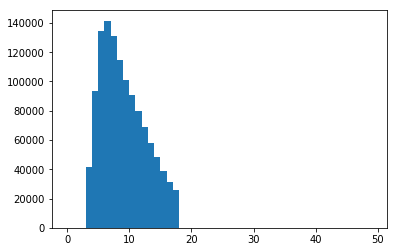

In [99]:
# Histogram of the lengths
%matplotlib inline

length_sentence = dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1)
plt.hist(length_sentence['sentence'],bins=range(50))
plt.show()

### Shuffle the Dataset

In [100]:

index = [i for i in range(dataset_df.shape[0])]
random.shuffle(index)
dataset = dataset_df.set_index([index]).sort_index()

dataset.head(1000)

,sentence,class
0,e ricoverati in ospedale,0
1,clark è geloso,1
2,il trasformatore 013 è fuori uso,1
3,lo so regana e ho ragione di crederlo,0
4,harry è è una delle cose più carine che tu mi ...,1
5,sono andato nell'edificio in cui lavora nolan ...,0
6,dovresti imitare quei bastardi spensierati e p...,0
7,dici che sono il topino piccino e tu il gatto ...,0
8,c'e un uomo con un cappotto blu che minaccia u...,0
9,sai cosa ti comporti come se tu fossi l'unico ...,1


In [101]:
exclude1 = ['\t', '"', '?', '!'] # list
exclude2 = ["'", "  ", "   ", "    ", "     "] # list

def clean_text(text):
    for c in exclude1:
        text=text.replace(c,'')
    for c in exclude2:
        text=text.replace(c, " ")
    return text.lower().strip()

sentence_processed = list(map(lambda text: clean_text(text), dataset['sentence'].values))

dataset['sentence'] = sentence_processed

dataset.head(1000)

,sentence,class
0,e ricoverati in ospedale,0
1,clark è geloso,1
2,il trasformatore 013 è fuori uso,1
3,lo so regana e ho ragione di crederlo,0
4,harry è è una delle cose più carine che tu mi ...,1
5,sono andato nell edificio in cui lavora nolan ...,0
6,dovresti imitare quei bastardi spensierati e p...,0
7,dici che sono il topino piccino e tu il gatto ...,0
8,c e un uomo con un cappotto blu che minaccia u...,0
9,sai cosa ti comporti come se tu fossi l unico ...,1


In [102]:
for i in range(10):
    print(dataset.iloc[i]['sentence'])
    print(dataset.iloc[-i -1]['sentence'])

e ricoverati in ospedale
doberdò comunque è un bel po
clark è geloso
quindi alla fine non è stato il post ad uccidere grétar
il trasformatore 013 è fuori uso
insomma mi ha aperto la porta e io
lo so regana e ho ragione di crederlo
perderò tutti i denti dovrò camminare con un bastone e infine giungerà la morte
harry è è una delle cose più carine che tu mi abbia mai detto
anche il professor leuschner ne è convinto
sono andato nell edificio in cui lavora nolan e ho passato un paio d ore nell ascensore
sapete aveva la mano tesa e mi fissava
dovresti imitare quei bastardi spensierati e prenderti un onda
beh ogni giorno è un regalo
dici che sono il topino piccino e tu il gatto gigantesco
l flq si è sciolto
c e un uomo con un cappotto blu che minaccia una donna con la pistola
e l ingegno dovrebbe essere applaudito
sai cosa ti comporti come se tu fossi l unico la cui vita è una vera merda
solo morire di vecchiaia è bello


In [103]:
toSubstitute = ['e', 'è'] # list

# def substitute_amniguity_old(text, placeholder):
#     for c in toSubstitute:
#         text=text.replace(c,placeholder)
#     return text.lower().strip()

def substitute_amniguity(text, placeholder):
    for c in toSubstitute:
        text=re.sub(r"\b%s\b" %(c),placeholder, text)
    return text.lower().strip()

placeholder = 'tannutuva'
sentence_processed = list(map(lambda text: substitute_amniguity(text,placeholder), dataset['sentence'].values))

dataset['sentence'] = sentence_processed

dataset.head(40)

,sentence,class
0,tannutuva ricoverati in ospedale,0
1,clark tannutuva geloso,1
2,il trasformatore 013 tannutuva fuori uso,1
3,lo so regana tannutuva ho ragione di crederlo,0
4,harry tannutuva tannutuva una delle cose più c...,1
5,sono andato nell edificio in cui lavora nolan ...,0
6,dovresti imitare quei bastardi spensierati tan...,0
7,dici che sono il topino piccino tannutuva tu i...,0
8,c tannutuva un uomo con un cappotto blu che mi...,0
9,sai cosa ti comporti come se tu fossi l unico ...,1


### Split for Semi-Supervised Dataset Learning (Train, Valid & Infer Sets)

In [ ]:
splitter = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=19850610)

splits = list(splitter.split(X=dataset['sentence'], y=dataset['class']))
main_index = splits[0][0]
test_index = splits[0][1]

main_df = dataset.loc[main_index,:]
print('Training-Set size: %d' %len(main_df))

test_df = dataset.loc[test_index,:]
print('Test-Set size: %d' %len(test_df))

In [ ]:
main_df = main_df.dropna()
len(main_df.dropna())

In [ ]:
test_df = test_df.dropna()
len(test_df.dropna())

In [ ]:
splitter =  model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.97, random_state=19850610)

splits = list(splitter.split(X=main_df['sentence'], y=main_df['class']))
train_index = splits[0][0]
infer_index = splits[0][1]

train_df = main_df.loc[train_index,:]
print('Training-Set size: %d' %len(train_df))

infer_df = main_df.loc[infer_index,:]
print('Inference-Set size: %d' %len(infer_df))

In [ ]:
train_df = train_df.dropna()
len(train_df)

In [ ]:
infer_df = infer_df.dropna()
len(infer_df)

In [ ]:
print("Training Set")
training_value_counts = train_df['class'].value_counts()
print(training_value_counts)
print("class 0 %: {}".format(round(training_value_counts[0]/len(train_df)*100,2)))
print("class 1 %: {}".format(round(training_value_counts[1]/len(train_df)*100,2)))
print("")
print("Test Set")
validation_value_counts = test_df['class'].value_counts()
print(validation_value_counts)
print("class 0 %: {}".format(round(validation_value_counts[0]/len(test_df)*100,2)))
print("class 1 %: {}".format(round(validation_value_counts[1]/len(test_df)*100,2)))
print("")
print("Inference Set")
inference_value_counts = infer_df['class'].value_counts()
print(inference_value_counts)
print("class 0 %: {}".format(round(inference_value_counts[0]/len(infer_df)*100,2)))
print("class 1 %: {}".format(round(inference_value_counts[1]/len(infer_df)*100,2)))

In [ ]:
train_df['class'] = train_df['class'].apply(lambda x: str(int(x)))
test_df['class'] = test_df['class'].apply(lambda x: str(int(x)))
infer_df['class'] = infer_df['class'].apply(lambda x: str(int(x)))

In [ ]:
train_df.to_csv('/home/asr/rd_ssDataLearning/dataset/six/train_sei_sslear.tsv', header=False, index=False, sep='\t')
test_df.to_csv('/home/asr/rd_ssDataLearning/dataset/six/test_sei_sslear.tsv', header=False, index=False, sep='\t')
infer_df.to_csv('/home/asr/rd_ssDataLearning/dataset/six/infer_sei_sslear.tsv', header=False, index=False, sep='\t')

### Split for Tagger Classifier (Train, Valid)

In [104]:

splitter =  model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=19850610)

splits = list(splitter.split(X=dataset['sentence'], y=dataset['class']))
train_index = splits[0][0]
valid_index = splits[0][1]

train_df = dataset.loc[train_index,:]
print('Training-Set size: %d' %len(train_df))

valid_df = dataset.loc[valid_index,:]
print('Validation-Set size: %d' %len(valid_df))

Training-Set size: 960000
Validation-Set size: 240000


In [105]:
print("Training Set")
training_value_counts = train_df['class'].value_counts()
print(training_value_counts)
print("class 0 %: {}".format(round(training_value_counts[0]/len(train_df)*100,2)))
print("class 1 %: {}".format(round(training_value_counts[1]/len(train_df)*100,2)))
print("")
print("Validation Set")
validation_value_counts = valid_df['class'].value_counts()
print(validation_value_counts)
print("class 0 %: {}".format(round(validation_value_counts[0]/len(valid_df)*100,2)))
print("class 1 %: {}".format(round(validation_value_counts[1]/len(valid_df)*100,2)))

Training Set
1    480000
0    480000
Name: class, dtype: int64
class 0 %: 50.0
class 1 %: 50.0

Validation Set
1    120000
0    120000
Name: class, dtype: int64
class 0 %: 50.0
class 1 %: 50.0


In [106]:
train_df.to_csv(os.path.join(ROOT_PATH, 'datasets/è_e/train_data_v5.tsv'), header=False, index=False, sep='\t')
valid_df.to_csv(os.path.join(ROOT_PATH, 'datasets/è_e/valid_data_v5.tsv'), header=False, index=False, sep='\t')

## Calculate Vocabulary and Save it

In [23]:
stop_words = get_stop_words('italian') 


#my_stop_words = ['puoi','posso','vediamo','guarda','vorrei','voglio','dici','fammi']
#my_stop_words = ['a','ad',"agl'",'agli', 'ai', "al'","all'", 'alla','alle','allo','ci','coi','col','di','e','il','la','le','li','lo']
#for my_word in my_stop_words:
#    stop_words.append(my_word)
    
# Important step for this dataset!!!!
#stop_words.remove('e')
#stop_words.remove('è')

In [24]:
'e' in stop_words

True

In [23]:
ww = ['criks', 'crjis3','cr456is', '45crist','1v','f4','16','l','9','5ffff56566778','cv']

falseIfDigit = lambda word: not bool((re.match('^(?=.*[0-9])', str(word))))

[w for w in ww if (falseIfDigit(w) or w.isdigit()) and (len(w) > 2 or w.isdigit()) ]

['criks', '16', '9']

In [25]:

# This function returns FALSE if there is a digit in the string (i.e '4mmm', 'm44m', 'llp4')
falseIfDigit = lambda word: not bool((re.match('^(?=.*[0-9])', str(word))))

def get_vocab():
    #allWords = []
    vocab = set()
    for text in train_df['sentence'].values:
        words = text.split(' ')
        # remove digits
        words_only = [w for w in words if not w.isdigit()]
        # exclude words shorter than 2, but not numbers. exclude words with numbers inside, i.e. '3cris', 'c45ris', 'cris23'
        #words_ = [w for w in words_only if (falseIfDigit(w) or w.isdigit()) and (len(w) > 2 or w.isdigit()) ]
        words_ = [w for w in words_only if len(w) > 0 ]
        #allWords = allWords + words_
        word_set = set(words_)
        vocab.update(word_set)
    
    #vocab.remove('')
    return list(vocab)#, allWords

def get_all_words():
    allWords = []
    cnt = 0
    for text in train_df['sentence'].values:
        words = text.split(' ')
        # remove digits
        words_only = [w for w in words if not w.isdigit()]
        # exclude words shorter than 2, but not numbers. exclude words with numbers inside, i.e. '3cris', 'c45ris', 'cris23'
        #words_ = [w for w in words_only if (falseIfDigit(w) or w.isdigit()) and (len(w) > 2 or w.isdigit()) ]
        words_ = [w for w in words_only if len(w) > 0 ]
        allWords = allWords + words_
        #word_set = set(words_)
        cnt += 1
        if cnt%10000==0:
            print('-----------', cnt)
    
    return allWords



In [32]:
%%time
vocab = get_vocab()
print('--------------------', len(vocab))


-------------------- 90523
CPU times: user 1.41 s, sys: 16 ms, total: 1.43 s
Wall time: 1.44 s


In [33]:
%%time
allWords = get_all_words()
print('--------------------', len(allWords))

----------- 10000
----------- 20000
----------- 30000
----------- 40000
----------- 50000
----------- 60000
----------- 70000
----------- 80000
----------- 90000
----------- 100000
----------- 110000
----------- 120000
----------- 130000
----------- 140000
----------- 150000
----------- 160000
----------- 170000
----------- 180000
----------- 190000
----------- 200000
----------- 210000
----------- 220000
----------- 230000
----------- 240000
----------- 250000
----------- 260000
----------- 270000
----------- 280000
----------- 290000
----------- 300000
-------------------- 2613352
CPU times: user 2h 7min 40s, sys: 1.5 s, total: 2h 7min 42s
Wall time: 2h 7min 44s


In [34]:
from collections import Counter
cnt_allWords = Counter(allWords)

In [35]:
vocab_words_sorted_by_appearence = sorted(cnt_allWords.items(), key=lambda kv: len(vocab) - kv[1])
#vocab_words_sorted_by_appearence

In [36]:
vocab_words_sorted_by_appearence_list = [word[0] for word in vocab_words_sorted_by_appearence]
#vocab_words_sorted_by_appearence_list, len(vocab_words_sorted_by_appearence_list)


In [58]:
STOP_WORDS = True
REDUCED_SIZE_VOC = True
SIZE_VOC = 5000

vocab = vocab_words_sorted_by_appearence_list

if STOP_WORDS:
    vocab = [w for w in vocab if w not in stop_words]
    words_and_frequence = [ (word, freq) for (word, freq) in vocab_words_sorted_by_appearence if word not in stop_words]

print(len(vocab))
if REDUCED_SIZE_VOC:
    vocab = vocab[0:SIZE_VOC]
print(len(vocab))


90224
5000


In [ ]:
#vocab[1000:]

### Building a Mixed Vocabulary
###### half of most frequent words, half of random selection among all the words (uniform distribution)

In [ ]:
# From 0 to boundary_point: words selected by their frequency (the most frequent words)
# From boundary_point to len(voc): words random selected
boundary_point = 19000

def random_selection_from_vocab(vocabulary, start):
    length_voc = len(vocabulary)
    vocab = np.array(vocabulary)
    indxs = np.random.choice(range(start, length_voc), length_voc - start, replace=False)
    return list(vocab[indxs])

vocab = vocab[0:boundary_point] + random_selection_from_vocab(vocab, boundary_point)
vocab[0:10]

In [ ]:
#words_and_frequence

In [78]:
# Check if a word is in VOC or STOP_WORDS
ww = 'e'
print('-----------------', ww in stop_words)
print('-----------------', ww in vocab)

----------------- False
----------------- False


In [59]:
PAD_WORD = '#=KS=#'

PATH_VOC = os.path.join(ROOT_PATH, 'datasets/è_e/vocab_5k_swout_v4.tsv')
with open(PATH_VOC , 'w') as file:
#with open('/home/asr/Data/classif_task/jsgf_data/vocab_list.tsv', 'w') as file:
    file.write("{}\n".format(PAD_WORD))
    for word in vocab:
        file.write("{}\n".format(word))
        
PATH_WORDS = os.path.join(ROOT_PATH, 'datasets/è_e/n_words_5k_swout_v4.tsv')        
with open(PATH_WORDS, 'w') as file:
#with open('/home/asr/Data/classif_task/jsgf_data/n_words.tsv', 'w') as file:
    file.write(str(len(vocab)))

